In [14]:
from typing import Tuple, List
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp, mannwhitneyu
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression


# Preprocess data
df = pd.read_csv("nvidia_10yr_data.csv", parse_dates=["Date"])
df['Date'] = pd.to_datetime(df['Date'], format="%d/%m/%Y")
df = df.sort_values("Date")

# Feature engineering
df['Return'] = df['Close'].pct_change()
df['Volatility'] = df['Close'].rolling(10).std()
df['Price_Diff'] = df['High'] - df['Low']
df['Volume_Log'] = np.log1p(df['Volume'])

# Drop NaN หลัง rolling
df.dropna(inplace=True)

X = df[['Return', 'Volatility', 'Price_Diff', 'Volume_Log']]
y = df['Close']


class DriftPointDetector:
    """
    ตรวจจับจุดเกิด concept drift ในข้อมูล time series ด้วยการใช้
    หลายวิธีทดสอบและป้องกันการจับ pattern ที่ผิดพลาด
    """
    def __init__(self, window_size: int = 120, threshold: float = 0.001, 
                 step_size: int = 30, min_effect_size: float = 0.3,
                 stability_window: int = 60, confirmation_tests: int = 2):
        self.window_size = window_size
        self.threshold = threshold
        self.step_size = step_size
        self.min_effect_size = min_effect_size  # ขนาดผลกระทบขั้นต่ำ
        self.stability_window = stability_window  # ช่วงเวลาที่ต้องมีเสถียรภาพ
        self.confirmation_tests = confirmation_tests  # จำนวนการทดสอบที่ต้องผ่าน
        self.drift_points_: List[int] = []

    def _calculate_effect_size(self, window1: pd.Series, window2: pd.Series) -> float:
        """คำนวณขนาดผลกระทบ (Cohen's d)"""
        mean1, mean2 = window1.mean(), window2.mean()
        std1, std2 = window1.std(), window2.std()
        
        # Pooled standard deviation
        pooled_std = np.sqrt(((len(window1) - 1) * std1**2 + (len(window2) - 1) * std2**2) / 
                           (len(window1) + len(window2) - 2))
        
        if pooled_std == 0:
            return 0
        
        return abs(mean1 - mean2) / pooled_std

    def _test_multiple_statistics(self, window1: pd.DataFrame, window2: pd.DataFrame) -> Tuple[int, float]:
        """ทดสอบหลายวิธีเพื่อยืนยัน drift"""
        passed_tests = 0
        min_p_value = 1.0
        
        for col in window1.columns:
            col_tests = 0
            col_p_values = []
            
            # Test 1: Kolmogorov-Smirnov test
            try:
                stat, p_value = ks_2samp(window1[col], window2[col])
                col_p_values.append(p_value)
                if p_value < self.threshold:
                    col_tests += 1
            except:
                pass
            
            # Test 2: Mann-Whitney U test
            try:
                stat, p_value = mannwhitneyu(window1[col], window2[col], alternative='two-sided')
                col_p_values.append(p_value)
                if p_value < self.threshold:
                    col_tests += 1
            except:
                pass
            
            # Test 3: Effect size check
            effect_size = self._calculate_effect_size(window1[col], window2[col])
            if effect_size > self.min_effect_size:
                col_tests += 1
            
            # อัปเดตค่า p-value ต่ำสุด
            if col_p_values:
                min_p_value = min(min_p_value, min(col_p_values))
            
            # ถ้าผ่านการทดสอบตามจำนวนที่กำหนด
            if col_tests >= self.confirmation_tests:
                passed_tests += 1
        
        return passed_tests, min_p_value

    def _check_stability_before_drift(self, X: pd.DataFrame, position: int) -> bool:
        """ตรวจสอบว่าช่วงก่อนหน้ามีเสถียรภาพหรือไม่"""
        if position < self.stability_window + self.window_size:
            return True
        
        # ตรวจสอบช่วงเสถียรภาพก่อนหน้า
        stable_start = position - self.stability_window - self.window_size
        stable_end = position - self.window_size
        stable_window = X.iloc[stable_start:stable_end]
        
        # แบ่งช่วงเสถียรภาพออกเป็น 2 ส่วน
        mid_point = len(stable_window) // 2
        stable_part1 = stable_window.iloc[:mid_point]
        stable_part2 = stable_window.iloc[mid_point:]
        
        # ถ้าช่วงเสถียรภาพยังมีการเปลี่ยนแปลงมาก แสดงว่าไม่เสถียร
        for col in X.columns:
            if len(stable_part1) > 0 and len(stable_part2) > 0:
                try:
                    stat, p_value = ks_2samp(stable_part1[col], stable_part2[col])
                    if p_value < self.threshold * 10:  # ใช้ threshold ที่หลวมกว่า
                        return False
                except:
                    pass
        
        return True

    def _remove_pattern_drifts(self, drift_candidates: List[Tuple[int, float]]) -> List[int]:
        """กรองจุด drift ที่อาจเป็น pattern"""
        if len(drift_candidates) < 3:
            return [pos for pos, _ in drift_candidates]
        
        # เรียงตาม position
        drift_candidates.sort(key=lambda x: x[0])
        
        # ตรวจสอบ pattern ที่เป็นช่วงเวลาเท่าๆ กัน
        intervals = []
        for i in range(1, len(drift_candidates)):
            interval = drift_candidates[i][0] - drift_candidates[i-1][0]
            intervals.append(interval)
        
        # ถ้ามี pattern ที่ซ้ำกัน (ช่วงเวลาใกล้เคียงกัน)
        filtered_drifts = []
        if len(intervals) > 1:
            # คำนวณความแปรปรวนของช่วงเวลา
            interval_std = np.std(intervals)
            interval_mean = np.mean(intervals)
            
            # ถ้าช่วงเวลาสม่ำเสมอเกินไป อาจเป็น pattern
            if interval_std / interval_mean < 0.3:  # coefficient of variation ต่ำ
                # เก็บเฉพาะจุดที่มี p-value ต่ำที่สุด
                drift_candidates.sort(key=lambda x: x[1])  # เรียงตาม p-value
                # เก็บ 1/3 ของจุดที่มีนัยสำคัญมากที่สุด
                keep_count = max(1, len(drift_candidates) // 3)
                filtered_drifts = [pos for pos, _ in drift_candidates[:keep_count]]
            else:
                filtered_drifts = [pos for pos, _ in drift_candidates]
        else:
            filtered_drifts = [pos for pos, _ in drift_candidates]
        
        # กรองจุดที่อยู่ใกล้กันเกินไป
        final_drifts = []
        min_distance = self.window_size * 2
        
        for pos in sorted(filtered_drifts):
            if not final_drifts or pos - final_drifts[-1] >= min_distance:
                final_drifts.append(pos)
        
        return final_drifts

    def detect(self, X: pd.DataFrame) -> List[int]:
        self.drift_points_ = []
        n = len(X)
        drift_candidates = []
        
        for i in range(self.window_size, n - self.window_size, self.step_size):
            # ตรวจสอบเสถียรภาพก่อนหน้า
            if not self._check_stability_before_drift(X, i):
                continue
            
            window1 = X.iloc[i - self.window_size:i]
            window2 = X.iloc[i:i + self.window_size]
            
            # ทดสอบหลายวิธี
            passed_tests, min_p_value = self._test_multiple_statistics(window1, window2)
            
            # ต้องผ่านการทดสอบอย่างน้อย 1 feature
            if passed_tests >= 1:
                drift_candidates.append((i, min_p_value))
        
        # กรอง pattern และจุดที่อยู่ใกล้กัน
        self.drift_points_ = self._remove_pattern_drifts(drift_candidates)
        
        return self.drift_points_


class AdaptiveFoldGenerator:
    """
    สร้าง train/test folds โดยแบ่งตาม drift points ที่ตรวจจับได้
    โดยจะข้ามช่วงที่สั้นเกินไป เพื่อให้แต่ละ fold มีขนาดพอเหมาะ
    """
    def __init__(self, min_fold_size: int = 120, test_ratio: float = 0.2):
        self.min_fold_size = min_fold_size
        self.test_ratio = test_ratio

    def split(self, X: pd.DataFrame, drift_points: List[int]) -> List[Tuple[np.ndarray, np.ndarray]]:
        folds = []
        points = [0] + drift_points + [len(X)]
        
        for i in range(len(points) - 1):
            start, end = points[i], points[i + 1]
            fold_length = end - start

            if fold_length < self.min_fold_size:
                continue  # ข้าม fold เล็ก ๆ

            split = int(start + (1 - self.test_ratio) * fold_length)
            train_idx = np.arange(start, split)
            test_idx = np.arange(split, end)

            if len(train_idx) > 50 and len(test_idx) > 20:  # ตรวจสอบขนาดขั้นต่ำ
                folds.append((train_idx, test_idx))
        
        return folds


class DriftAdaptiveTimeSeriesCV:
    """
    ทำ cross-validation โดยใช้ fold ที่แบ่งตาม drift points
    ใช้ pipeline ที่กำหนดไว้ภายนอก (รับ parameter pipeline)
    """
    def __init__(self, pipeline: Pipeline):
        self.pipeline = pipeline

    def run(self, X: pd.DataFrame, y: pd.Series, drift_points: List[int]) -> Tuple[List[float], List[float]]:
        fold_gen = AdaptiveFoldGenerator()
        metrics_rmse, metrics_mae = [], []

        folds = fold_gen.split(X, drift_points)
        if not folds:
            print("Warning: No valid folds generated by AdaptiveFoldGenerator!")
            return [], []

        for i, (train_idx, test_idx) in enumerate(folds):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            # ใช้ pipeline ที่ส่งเข้ามา ไม่สร้างใหม่
            self.pipeline.fit(X_train, y_train)
            y_pred = self.pipeline.predict(X_test)

            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            mae = mean_absolute_error(y_test, y_pred)
            print(f"[Adaptive Fold {i+1}] RMSE={rmse:.4f}, MAE={mae:.4f}")

            metrics_rmse.append(rmse)
            metrics_mae.append(mae)

        return metrics_rmse, metrics_mae


class BaselineTimeSeriesCV:
    """
    ทำ cross-validation แบบ TimeSeriesSplit ปกติ
    โดยใช้ pipeline ที่กำหนดไว้ภายนอก (รับ parameter pipeline)
    """
    def __init__(self, pipeline: Pipeline, n_splits: int = 5):
        self.pipeline = pipeline
        self.n_splits = n_splits

    def run(self, X: pd.DataFrame, y: pd.Series) -> Tuple[List[float], List[float]]:
        tscv = TimeSeriesSplit(n_splits=self.n_splits)
        metrics_rmse, metrics_mae = [], []

        for i, (train_idx, test_idx) in enumerate(tscv.split(X)):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            self.pipeline.fit(X_train, y_train)
            y_pred = self.pipeline.predict(X_test)

            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            mae = mean_absolute_error(y_test, y_pred)
            print(f"[Baseline Fold {i+1}] RMSE={rmse:.4f}, MAE={mae:.4f}")

            metrics_rmse.append(rmse)
            metrics_mae.append(mae)

        return metrics_rmse, metrics_mae


# --------------------------------------------------------
# ตัวอย่างการใช้งาน
if __name__ == "__main__":
    np.random.seed(42)

    # Pipeline สำหรับ Baseline TimeSeriesSplit CV (Linear Model)
    baseline_pipeline = Pipeline([
        ('scale', StandardScaler()),
        ('regressor', LinearRegression())
    ])

    # Pipeline สำหรับ Adaptive CV (Random Forest)
    adaptive_pipeline = Pipeline([
        ('scale', StandardScaler()),
        ('regressor', RandomForestRegressor(
            n_estimators=100,
            max_depth=5,
            min_samples_leaf=10,
            random_state=42
        )) 
    ])
    
    # 1) Detect drift points with improved detector
    detector = DriftPointDetector(
        window_size=120, 
        threshold=0.001, 
        step_size=30,
        min_effect_size=0.3,
        stability_window=60,
        confirmation_tests=2
    )
    drift_points = detector.detect(X)
    print(f"Detected drift points at indices: {drift_points}")
    print(f"Total drift points found: {len(drift_points)}")

    # 2) Run Adaptive CV
    drift_cv = DriftAdaptiveTimeSeriesCV(adaptive_pipeline)
    print("\n--- Drift-Aware Adaptive CV ---")
    drift_rmse, drift_mae = drift_cv.run(X, y, drift_points)

    # 3) Run Baseline TimeSeriesSplit CV
    baseline_cv = BaselineTimeSeriesCV(baseline_pipeline, n_splits=5)
    print("\n--- Baseline TimeSeriesSplit CV ---")
    base_rmse, base_mae = baseline_cv.run(X, y)

    # 4) สรุปเปรียบเทียบผลลัพธ์
    print("\n===== Summary Metrics =====")
    if drift_rmse and drift_mae:
        print(f"Adaptive CV - Avg RMSE: {np.mean(drift_rmse):.4f}, Avg MAE: {np.mean(drift_mae):.4f}")
    else:
        print("Adaptive CV - No valid results")
    
    if base_rmse and base_mae:
        print(f"Baseline CV - Avg RMSE: {np.mean(base_rmse):.4f}, Avg MAE: {np.mean(base_mae):.4f}")
    else:
        print("Baseline CV - No valid results")

Detected drift points at indices: [120, 420, 660, 1110, 1350, 1710, 1950, 2190]
Total drift points found: 8

--- Drift-Aware Adaptive CV ---
[Adaptive Fold 1] RMSE=0.0186, MAE=0.0152
[Adaptive Fold 2] RMSE=0.5766, MAE=0.5583
[Adaptive Fold 3] RMSE=1.2342, MAE=1.1804
[Adaptive Fold 4] RMSE=1.3213, MAE=1.1706
[Adaptive Fold 5] RMSE=1.6547, MAE=1.4202
[Adaptive Fold 6] RMSE=6.8672, MAE=6.7037
[Adaptive Fold 7] RMSE=3.7664, MAE=3.4267
[Adaptive Fold 8] RMSE=10.4554, MAE=8.5569
[Adaptive Fold 9] RMSE=22.0899, MAE=19.3601

--- Baseline TimeSeriesSplit CV ---
[Baseline Fold 1] RMSE=1.7622, MAE=1.3741
[Baseline Fold 2] RMSE=2.1970, MAE=1.6823
[Baseline Fold 3] RMSE=4.7748, MAE=3.9555
[Baseline Fold 4] RMSE=8.3381, MAE=6.0330
[Baseline Fold 5] RMSE=32.6020, MAE=26.6973

===== Summary Metrics =====
Adaptive CV - Avg RMSE: 5.3316, Avg MAE: 4.7102
Baseline CV - Avg RMSE: 9.9348, Avg MAE: 7.9484


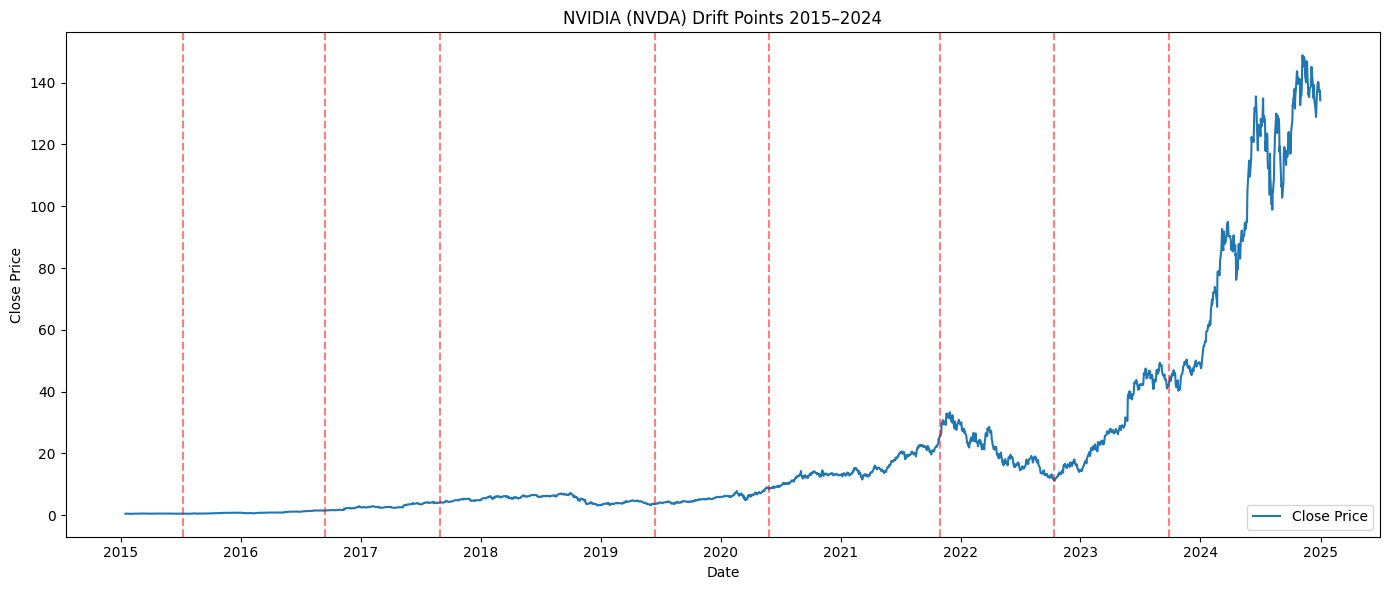

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(df['Date'], y, label='Close Price')
for i in drift_points:
    plt.axvline(df['Date'].iloc[i], color='red', linestyle='--', alpha=0.5)
plt.title("NVIDIA (NVDA) Drift Points 2015–2024")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.show()
